In [22]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

import gensim
from gensim.models.keyedvectors import KeyedVectors


In [15]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 25000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 2048
EPOCHS = 10

In [3]:
# load dataset 
train = pd.read_csv("C:\\Users\\PC\\Desktop\\Advanced NLP\\Data\\ToxicComment\\train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

In [4]:
# Convert the sentences into integers, Tokenization
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
print("sequences:", sequences)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [6]:
# padding
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
data.shape

(159571, 100)

In [7]:
print("loading word2vec model…")
word2vec_model = KeyedVectors.load_word2vec_format('D:\\WordEmbeddings\\GoogleNews-vectors-negative300.bin', binary=True)

loading word2vec model…


C:\Users\PC\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [8]:
def getVector(str):
    if str in word2vec_model:
        return word2vec_model[str]
    else:
        return None
    
def isInModel(str):
    return str in word2vec_model

In [9]:
# create a weight matrix for words in training docs
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
print(num_words)
embedding_matrix = np.zeros((num_words, 300))

for word, i in word2idx.items():
    if i < num_words:
        embedding_vector = getVector(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

25000


In [10]:
# load pre-trained word embeddings into embedding layer
embedding_layer = Embedding(input_dim = num_words, output_dim = EMBEDDING_DIM, weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH, trainable = False)

In [33]:
# Build Model

input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# Bidirectional
x = (LSTM(20, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

In [34]:
model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy']
)

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          7500000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 100, 20)           25680     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 126       
Total params: 7,525,806
Trainable params: 25,806
Non-trainable params: 7,500,000
_________________________________________________________________


In [19]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 11s 84us/step - loss: 0.2079 - acc: 0.9507 - val_loss: 0.1364 - val_acc: 0.9635
Epoch 2/10
127656/127656 [==============================] - 10s 80us/step - loss: 0.1305 - acc: 0.9633 - val_loss: 0.1245 - val_acc: 0.9635
Epoch 3/10
127656/127656 [==============================] - 10s 81us/step - loss: 0.1159 - acc: 0.9633 - val_loss: 0.1031 - val_acc: 0.9635
Epoch 4/10
127656/127656 [==============================] - 10s 80us/step - loss: 0.0851 - acc: 0.9680 - val_loss: 0.0710 - val_acc: 0.9765
Epoch 5/10
127656/127656 [==============================] - 10s 81us/step - loss: 0.0635 - acc: 0.9796 - val_loss: 0.0633 - val_acc: 0.9794
Epoch 6/10
127656/127656 [==============================] - 10s 79us/step - loss: 0.0569 - acc: 0.9811 - val_loss: 0.0575 - val_acc: 0.9807
Epoch 7/10
127656/127656 [==============================] - 10s 79us/step - loss: 0.0538 - 

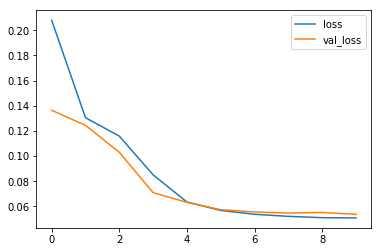

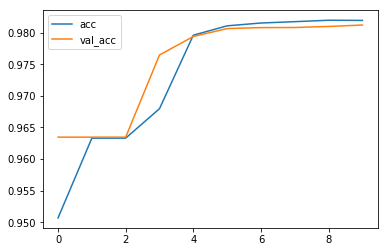

In [20]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [21]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9729812205220773
